In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1)
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

In [149]:
txt_filelist = os.listdir(os.path.join(os.getcwd(),'Red Sweep Opening'))
int_time = 0.001
k_filepath = 'flame_to_irradiance_calibrationfile.txt'
spectra_data = None
bg_spectra = np.loadtxt(os.path.join('Red Sweep Opening',txt_filelist[0]), skiprows=1)

for i in range(len(txt_filelist)-1):
    load_spectra = np.loadtxt(os.path.join('Red Sweep Opening',txt_filelist[i]), skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data = actual_irradiance_spectra
    else:
        spectra_data = np.dstack((spectra_data, actual_irradiance_spectra))

cut_wl_relation = np.loadtxt(os.path.join('Red Sweep Opening','Red Sweep Opneing - cutting wavelenght relation.txt'), skiprows=1)#Dividing Wavelength To Motor Position Calibration File.txt

No handles with labels found to put in legend.


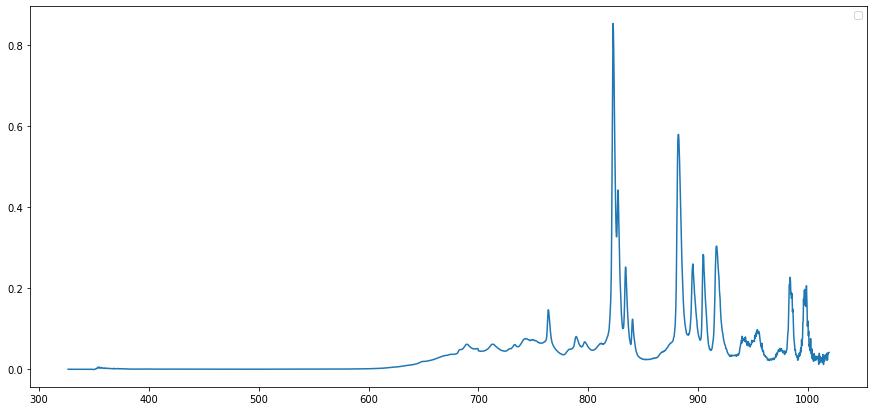

In [151]:
j = 20

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(spectra_data[:,0,j], spectra_data[:,1,j])
#plt.ylim(0,2)
ax.legend()


In [152]:
txt_filelist_measure = os.listdir(os.path.join(os.getcwd(),'Red Sweep Opening Raw IV Curves - L06'))
txt_filelist_measure=np.flip(txt_filelist_measure)
measure_Jsc = np.zeros(len(txt_filelist_measure))

for j in range(len(txt_filelist_measure)):
    actual_file_data = np.loadtxt(os.path.join(os.getcwd(),'Red Sweep Opening Raw IV Curves - L06', txt_filelist_measure[j]), skiprows=1)
    actual_jsc_index = np.where(actual_file_data[:,0] == closest(actual_file_data[:,0], 0))
    actual_jsc_value = actual_file_data[actual_jsc_index[0],2]
    measure_Jsc[j] = -actual_jsc_value

    

In [157]:
#We load the measurements:

measurement_data= np.loadtxt('MCV.210604.OF2..Red Sweep Opening.txt', skiprows=1)
#measurement_data= np.loadtxt('MCV.210921.0830ThY62.ForEQEmeasurement..Red Sweep Opening.txt', skiprows=1)
#measurement_data= np.loadtxt('MCV.210803.0712OT2.1SUN210712..Red Sweep Opening.txt', skiprows=1)

measure_Jsc = -0.1*measurement_data[:,2]

#for i in range(len(measure_Jsc)):
#    measure_Jsc[i] = measure_Jsc[i]-measure_Jsc[0]



measure_divwl = measurement_data[:,0]
min_cutwl = np.min(measure_divwl)
#min_cutwl = 410
max_cutwl = np.max(measure_divwl)
inc_cutwl = abs(min_cutwl-max_cutwl)/(len(measure_divwl)-1)
print(min_cutwl, max_cutwl)



360.0 760.0


In [158]:
#calibration_motor_position = np.arange(0,50.2,0.2)
spectra_matrix = None
spectra_matrix_wls = spectra_data[:,0,0]
for i in range(len(measure_divwl)):
    actual_cutwl = measure_divwl[i]
    cut_wl_relation_index_cutwl = np.where(cut_wl_relation[:,0] == actual_cutwl)[0]
    spectra_data_actual_index = np.where(calibration_motor_position[:] == closest(calibration_motor_position[:], cut_wl_relation[cut_wl_relation_index_cutwl,1]))
    actual_cut_wl_spectra = np.transpose(spectra_data[:,1,spectra_data_actual_index[0]])
    #print([actual_cut_wl, cut_wl_relation[actual_spectra_data_index_cutwl[0],2]])
    actual_spectra_matrix_cut_wl = cut_wl_relation[cut_wl_relation_index_cutwl[0],1]
    if i == 0:
        spectra_matrix_cutwl = actual_spectra_matrix_cut_wl
        spectra_matrix_cutwl_ideal = actual_cutwl
        spectra_matrix = actual_cut_wl_spectra
    else:
        spectra_matrix_cutwl = np.vstack((spectra_matrix_cutwl, actual_spectra_matrix_cut_wl))
        spectra_matrix_cutwl_ideal = np.vstack((spectra_matrix_cutwl_ideal, actual_cutwl))
        spectra_matrix = np.vstack((spectra_matrix, actual_cut_wl_spectra))

ValueError: operands could not be broadcast together with shapes (251,) (0,) 

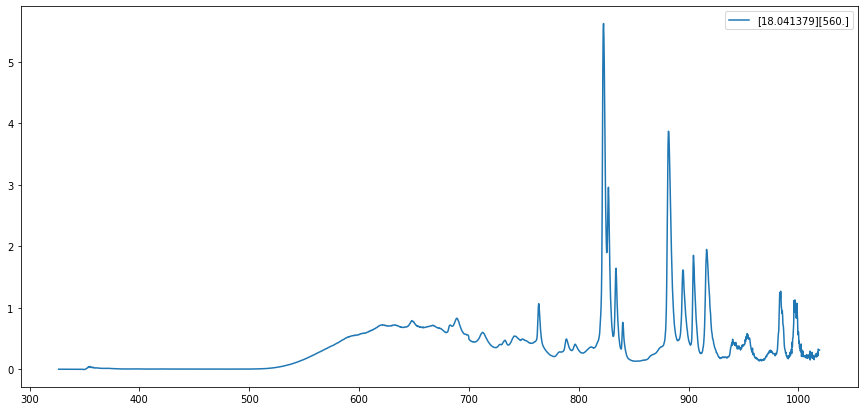

In [69]:
j = 40
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
ax.legend()

In [116]:
#Now we construct the c matrix

ideal_max = int(np.max(spectra_matrix_cutwl_ideal))
ideal_min = int(np.min(spectra_matrix_cutwl_ideal))
#mintomax_wl_distrib = np.linspace(ideal_min-inc_cutwl/2, ideal_max+inc_cutwl/2, ideal_max-ideal_min+int(inc_cutwl)+1)#print(mintomax_wl_distrib)
mintomax_wl_distrib = np.arange(ideal_min-inc_cutwl/2, 1000+inc_cutwl/2, 1)
c_matrix_wl = np.arange(ideal_min, 1000,1)
c_matrix = np.zeros((len(spectra_matrix_cutwl_ideal),len(c_matrix_wl)))
inc_cutwl = 1
EQE_int_const = np.linspace(1, 0.8, len(c_matrix[:,0]))
for i in range(len(c_matrix[:,0])):
    actual_spectra_interpolation = interpolate.interp1d(spectra_matrix_wls, spectra_matrix[i,:], kind='cubic')
    iteration_wl = spectra_matrix_cutwl[i]
    
    for j in range(len(c_matrix_wl)):
       
        #actual_spectra_average = statistics.mean(actual_spectra_interpolation(mintomax_wl_distrib[10*j:10*(j+1)]))
        actual_spectra_average = actual_spectra_interpolation(c_matrix_wl[j])
        c_matrix[i,j] = 0.01*inc_cutwl*actual_spectra_average/1240*c_matrix_wl[j]#*EQE_int_const[i]
        # if abs(c_matrix[i,j])<= 0.002 or  c_matrix[i,j]<=0:
        #     c_matrix[i,j] = 0
        
            

#c_matrix = np.flip(c_matrix, axis=1)


        

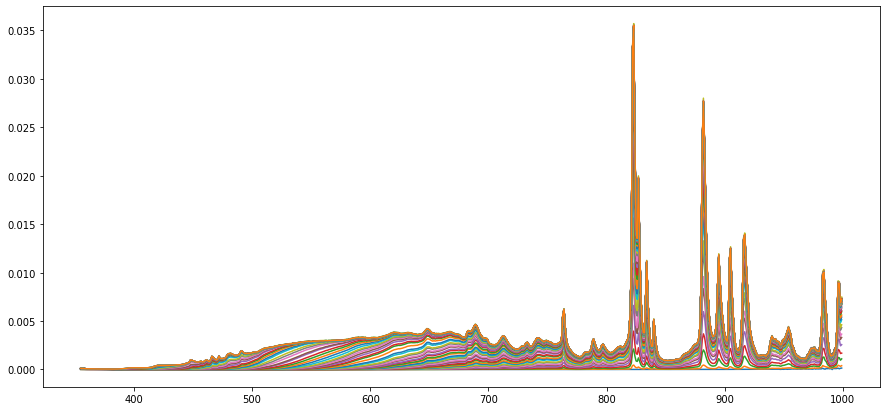

In [117]:
#c_matrix[:,-1:-3] =
fig, ax = plt.subplots(figsize=(15,7))
for j in range(len(c_matrix[:,0])):
    
    #ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
    ax.plot(c_matrix_wl, c_matrix[j,:])#, label=str(j))#c_matrix_wl,
    #ax.legend()


In [142]:
#Here we do the calculations with the linear equations system
print(c_matrix.shape, measure_Jsc.shape)
EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix, measure_Jsc, rcond=None)



#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))

#print(EQE_linearsolution)
#ax.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), 1*np.array(sf.Extract_Column(Active_layer_1.EQE_curve, 1)), label = 'Real EQE')
ax.plot(c_matrix_wl, EQE_linearsolution, label = 'Calculated EQE')
#ax.plot(spectra_data[:,0,20],spectra_data[:,1,99])
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


(251, 60) (21,)


LinAlgError: Incompatible dimensions

In [36]:
invA = np.linalg.inv(c_matrix)
EQE_linearsolution = np.dot(invA,measure_Jsc)

fig, ax = plt.subplots(figsize=(15,7))


ax.plot(measure_divwl, 0.1*EQE_linearsolution, label = 'Calculated EQE')
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)

LinAlgError: Last 2 dimensions of the array must be square

In [ ]:
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(c_matrix[j,:])):
        summ=summ+c_matrix[j,i]*EQE_linearsolution[i]

    print(summ, measure_Jsc[j])

In [139]:
#Try to get a first aproximation of the EQE with the step function idea
EQE_stepf_aprox = np.zeros((len(measure_Jsc), 2))
#flip_c_matrix = np.flip(c_matrix, axis=0)

for i in range(len(measure_Jsc)):
    if i<(len(measure_Jsc)-1):
        EQE_stepf_aprox[i,0] = measure_divwl[i]
        aaa = np.where(c_matrix_wl[:] == measure_divwl[i])[0]
        actual_EQE = (measure_Jsc[i+1]-measure_Jsc[i])/inc_cutwl/c_matrix[-1,aaa[0]]
        EQE_stepf_aprox[i,1] = 30*actual_EQE
    else:
        EQE_stepf_aprox[i,0] = measure_divwl[i]
        EQE_stepf_aprox[i,1] = EQE_stepf_aprox[i-1,1]
    
real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(EQE_stepf_aprox[:,0], EQE_stepf_aprox[:,1], label = 'Calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.legend()
plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)

IndexError: index 0 is out of bounds for axis 0 with size 0

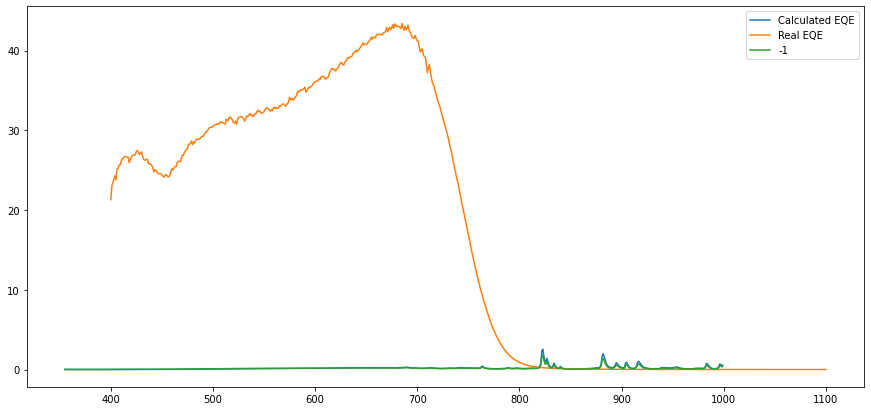

In [120]:
def EQE_minimize(EQE_solution,A,b):    
    AEQE_product = np.dot(A,EQE_solution)
    EQE_minimize = abs(AEQE_product[:]-b[:])
    EQE_diff_summ = np.sum(EQE_minimize[:])
    if EQE_diff_summ <=10:
        print (EQE_diff_summ)

    return np.sum(EQE_diff_summ)

#c_matrix[:,45:] = 0

bnds = optimize.Bounds(0, 100)

EQE_0 = np.zeros(len(c_matrix_wl))

#for i in range(len(EQE_stepf_aprox)):
#    EQE_0[-i] = EQE_stepf_aprox[i,1]

#print(EQE_approximation, EQE_aproximation[:,0])
#EQE_aproximation[:] = 30*EQE_aproximation[:]
minimize_solution = optimize.minimize(EQE_minimize, EQE_0[:], args = (c_matrix, measure_Jsc),bounds=bnds, tol=0.2)
EQE_minimize_solution = minimize_solution.x
real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)
fig, ax = plt.subplots(figsize=(15,7))
#EQE_approximation[-1,0] = 350
ax.plot(c_matrix_wl, 1*EQE_minimize_solution, label = 'Calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
j=-1
ax.plot(c_matrix_wl,50*c_matrix[j,:], label=str(j))
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)



In [104]:
print(len(c_matrix[j,:]))
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(c_matrix[j,:])):
        #if 41<=i:
        summ=summ+c_matrix[j,i]*EQE_minimize_solution[i]

    print(summ, measure_Jsc[j])

65
0.10356024510511232 -0.013125
0.7140750351667022 -2.083504
2.616843115572718 -9.32521
4.626311844777264 -18.582563
7.32288748639991 -26.856238
10.018991441597505 -36.333787
11.409846170584906 -46.293613
14.191731911454525 -55.8948
15.375023362370834 -64.538263
17.869209702338694 -74.345788
19.12079901512844 -82.3008
20.268119524029913 -89.623725
22.31808627913935 -99.115737
23.34986944574454 -107.678063
25.241728489491752 -113.733212
26.180967484295575 -117.91205
26.8765704184296 -125.021375
28.39827752439804 -131.6315
29.07558974871157 -139.030125
29.74985535807692 -143.605875
30.396836446835938 -145.673625
31.466091785589803 -151.254125
32.088607449703595 -158.567375
33.08239627537648 -160.7865
33.4836142651488 -163.917625
34.26799556333122 -167.162
34.723056835435685 -172.71375
35.431557622230116 -174.919375
35.86205278697593 -177.6475
36.80969780479826 -182.43675
37.2795997019901 -185.99625
38.3776059278367 -190.474125
39.332210000500794 -195.442375
39.74337028173308 -199.1485
4

KeyboardInterrupt: 

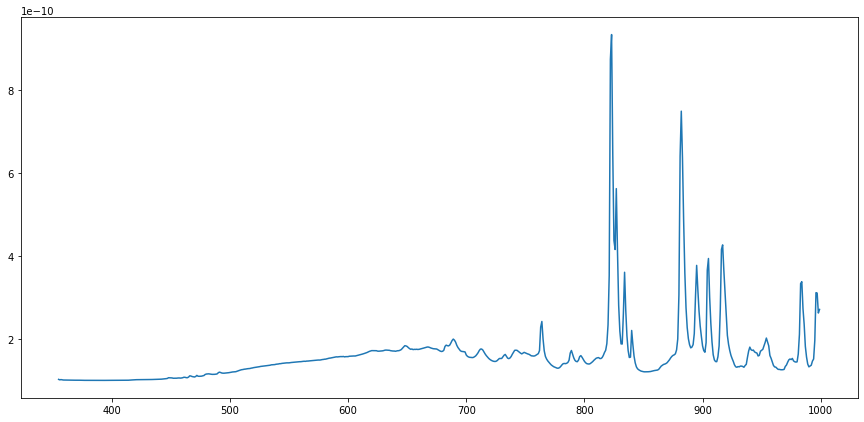

In [121]:
def EQE_minimize(EQE_solution,A,b):    
    AEQE_product = np.dot(A,EQE_solution)
    EQE_minimize = abs(AEQE_product[:]-b[:])**2
    EQE_diff_summ = np.sum(EQE_minimize[:])
    # if EQE_diff_summ <=10:
    #     print (EQE_diff_summ)

    return np.sum(EQE_diff_summ)

#c_matrix[:,45:] = 0

bnds = optimize.Bounds(0, 100)

fig, ax = plt.subplots(figsize=(15,7))
EQE_0 = np.zeros((len(c_matrix_wl)))
EQE_minimize_coef = np.zeros((4))
EQE_minimize_solution_all = np.zeros((len(c_matrix_wl),len(EQE_minimize_coef)))
for j in range(len(EQE_minimize_coef)):
    for i in range(len(EQE_0)):
        if i<=56:
            EQE_0[i] = 5*j

    #minimize_solution = optimize.minimize(EQE_minimize, EQE_0[:], args = (c_matrix, measure_Jsc),bounds=bnds, )   
    minimize_solution = optimize.least_squares(EQE_minimize, EQE_0[:], args = (c_matrix, 0.1*measure_Jsc),bounds=(0,100), )             
    EQE_minimize_solution_all[:,j]= minimize_solution.x
    EQE_minimize_coef[j] = EQE_minimize(EQE_minimize_solution_all[:,j],c_matrix,measure_Jsc)
    ax.plot(c_matrix_wl, 1*EQE_minimize_solution_all[:,j], label = str(j)+'/'+str(EQE_minimize_coef[j]))


#print(EQE_approximation, EQE_aproximation[:,0])
#EQE_aproximation[:] = 30*EQE_aproximation[:]


real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)

#EQE_approximation[-1,0] = 350
#ax.plot(c_matrix_wl, 300*EQE_minimize_solution, label = 'Calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
j=-1
ax.plot(c_matrix_wl,50*c_matrix[j,:], label=str(j))
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)


In [ ]:
print(len(c_matrix[j,:]))
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(EQE_minimize_solution_all[:,2])):
        #if 41<=i:
        summ=summ+c_matrix[j,i]*EQE_minimize_solution_all[i,2]

    print(summ, measure_Jsc[j])

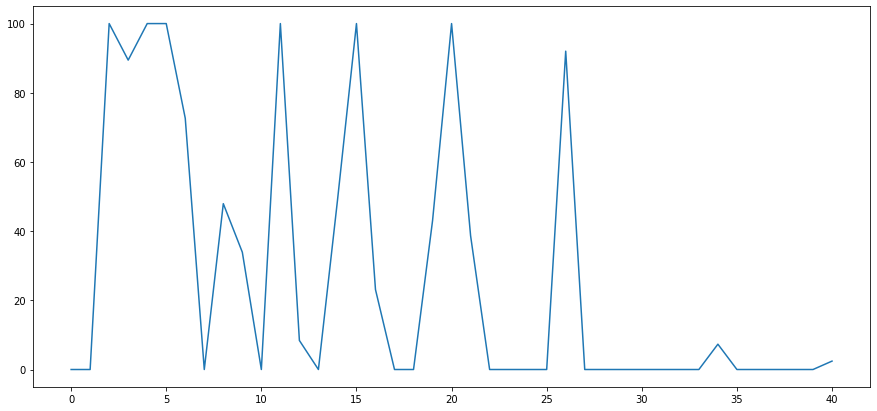

In [265]:
result=optimize.lsq_linear(c_matrix[:,0:len(measure_Jsc)], measure_Jsc, bounds=(0,100), lsq_solver = 'lsmr')

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(result.x)

In [ ]:
print(len(c_matrix[j,:]))
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(result.x)):
        #if 41<=i:
        summ=summ+c_matrix[j,i]*result.x[i]

    print(summ, measure_Jsc[j])

In [159]:
#Now we will make a small simulation calculating the Jsc for the different imput spectras and try to gent the EQE from that data: 
Jsc_correction_factor = 1
real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)
EQE_interpolation = interpolate.interp1d(real_EQE[:,0], real_EQE[:,1], kind='cubic')
c_matrix_wl = np.arange(400, 1000, 10)
c_matrix = np.zeros((len(spectra_data[0,0,:]), len(c_matrix_wl[:])))
inc_cutwl = 10
Jsc_calculated = np.zeros(len(c_matrix[:,0]))

for j in range(len(c_matrix[:,0])):
    spectra_interpolation = interpolate.interp1d(spectra_data[:,0,j], spectra_data[:,1,j], kind='cubic')
    Jsc_summ = 0
    for i in range(len(c_matrix[0,:])):
        actual_wl = c_matrix_wl[i]
        actual_spectra = spectra_interpolation(c_matrix_wl[i])
        c_matrix[j,i] = 0.1*inc_cutwl*actual_spectra/1240*actual_wl
        Jsc_summ = Jsc_summ + 0.01*Jsc_correction_factor*EQE_interpolation(actual_wl)*inc_cutwl*actual_wl*actual_spectra/1240
    Jsc_calculated[j] = Jsc_summ


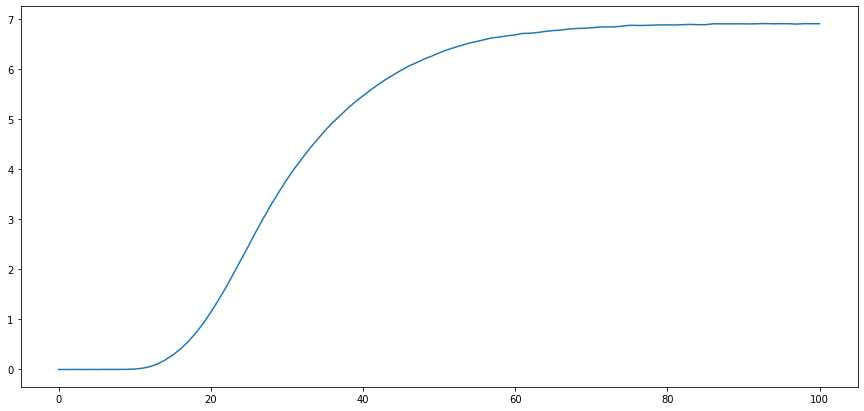

In [160]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Jsc_calculated[:])

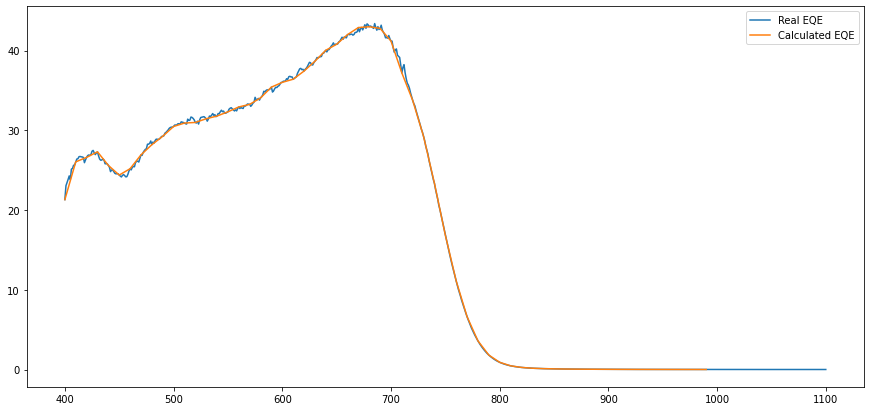

In [161]:
#Here we do the calculations with the linear equations system

EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix, Jsc_calculated, rcond=None)
#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))

#print(EQE_linearsolution)
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, 10*EQE_linearsolution, label = 'Calculated EQE')
#ax.plot(spectra_data[:,0,20],spectra_data[:,1,99])
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


IndexError: index 82 is out of bounds for axis 0 with size 82

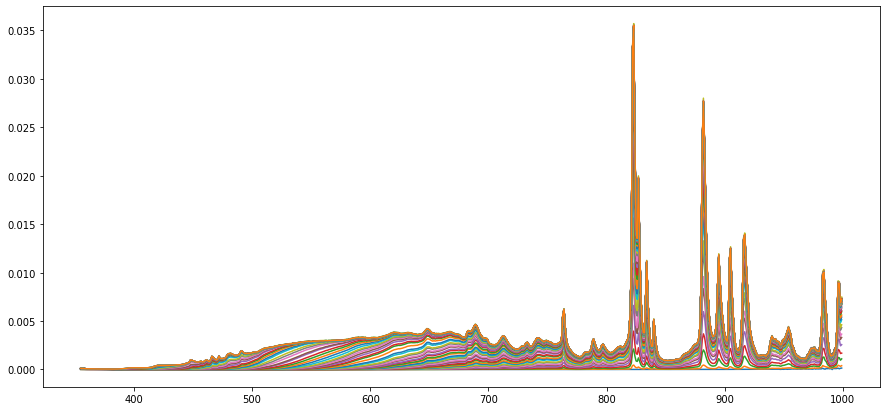

In [131]:
fig, ax = plt.subplots(figsize=(15,7))
for j in range(0,83):
    ax.plot(c_matrix_wl, c_matrix[j,:], label=str(j))

plt.ylim(0,1)
#ax.legend()